In [1]:
import os
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

font = {
    # 'family' : 'normal',
    # 'weight' : 'bold',
    'size'   : 16}

plt.rc('font', **font)

font = {'family' : 'serif',
        #  'size'   : 26,
         'serif':  'cmr10'
         }
plt.rc('font', **font)
# plt.rcParams.update({'font.size': 26})

def read_csvs(training_results):
    big_df: pd.DataFrame = None

    image_files_FINAL  = [file[12:-4] for file in os.listdir(f"{training_results}")]
    for f in image_files_FINAL:
        if f.split('__') == ['']:
            continue
        # print(f.split('__'))
        try:
            print(f.split('__'))
            architecture, encoder, loss, encoder_freeze, dataset, lr = f.split('__') # Try to extract LR
            lr = lr[3:]
            # print(f"{training_results}/best_model__{architecture}__{encoder}__{loss}__{encoder_freeze}__{dataset}__LR_{lr}.csv")
            df = pd.read_csv(f"{training_results}/best_model__{architecture}__{encoder}__{loss}__{encoder_freeze}__{dataset}__LR_{lr}.csv", index_col=0)
        except:
            lr = 0.0001 # The rest are 1e-4
            architecture, encoder, loss, encoder_freeze, dataset = f.split('__') 
            df = pd.read_csv(f"{training_results}/best_model__{architecture}__{encoder}__{loss}__{encoder_freeze}__{dataset}.csv", index_col=0)
            
        df['architecture'] = architecture
        df['encoder'] = encoder
        df['loss_func'] = loss
        df['dataset'] = dataset
        df['lr'] = lr
        if type(big_df) == 'NoneType':
            big_df = df
        else:
            big_df = pd.concat((big_df, df))
    return big_df

loss_color_dict = {
    'JaccardLoss': '#e6194b',
    'BCEJaccardLoss': '#000075',
    'DiceLoss': '#3cb44b',
    'BCEDiceLoss': '#4363d8',
    'BCELoss': '#f58231',
    'FocalLoss': '#000000',
    'BinaryLovaszLoss': '#46f0f0',
    'JaccardLoss_old': 'pink',
}

architecture_color_dict = {
    'Unet': '#e6194b',
    'Linknet': '#000075',
    'PSPNet': '#4363d8',
    'MAnet': '#f58231',
    'DeepLabV3Plus': '#000000',
    'FPN': '#46f0f0',
    'PAN': '#f032e6',
    'UnetPlusPlus':'#9a6324'
}

encoder_color_dict = {
    'resnet101': '#e6194b',
    'resnet34': '#000075',
    'efficientnet-b2': '#3cb44b',
    'efficientnet-b1': '#4363d8',
    'xception41': '#f58231',
}

dataset_feature_color_dict = {
    'two_channel': '#e6194b',
    'normal': '#000075',
    'gradient': '#3cb44b',
}

In [2]:
def sort_data(big_df, y_column, filters=None):
    big_df_copy = big_df.copy(deep=True)
    if filters != None:
        big_df_copy.query(filters, inplace=True)

    data_sorted = []
    for data in big_df_copy.groupby(['architecture', 'encoder', 'loss_func', 'freeze_encoder', 'dataset', 'lr']):
        # architecture, encoder, loss, freeze, dataset = data[0]
        data_sorted.append((data, np.max(data[1][y_column]))) # data, highest score 
    return data_sorted

def create_table(big_df: pd.DataFrame, axs, row, col, y_column, data_name, table_data_name, text_letter=None, filters=None):
    data_sorted = sort_data(big_df, y_column, filters)
    max_val_ious = [(max_val_iou[0][0][data_name], round(max_val_iou[1],5)) for max_val_iou in data_sorted]
    max_val_ious = sorted(max_val_ious, key=lambda x: x[1], reverse=True)
    axs[row, col].axis('off')
    axs[row, col].table(cellText=max_val_ious,
                    # rowLabels=rows,
                    # rowColours=colors,
                    colLabels=(table_data_name, "Val IoU"),
                    loc='center')
    if text_letter is not None:
        axs[row,col].text(.025, .925, text_letter, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=axs[row,col].transAxes)


def create_sub_fig(big_df, axs: plt.Axes, row, col, y_column, y_column_name, plot_title, data_name, color_dict,
                   text_letter=None, x_column=None, x_column_name="Epochs", legend=True, loc='lower right', 
                   filters=None, legend_font_size=10, letter_font_size=20, title=False, static_color:str = None, 
                   static_label:str = None, **plot_options):
    if len(axs.shape) == 1:
        index = col 
    else: #axs.shape == (2, 2): # Handle different shape plots
        index = (row,col)
    # else:
    #     raise Exception("Unknown dims. Shape:", axs.shape)

    data_sorted = sort_data(big_df, y_column, filters)

    for i, data in enumerate(sorted(data_sorted, key=lambda x: x[1], reverse=True)):
        # print(data[0][1][y_column][:20])
        # try:
        #     architecture, encoder, loss, freeze, dataset, lr = data[0][0] # Try to extract LR
        # except:
        #     architecture, encoder, loss, freeze, dataset = data[0][0] 
        
        if x_column == None:
            x_column_ = list(range(len(data[0][1][y_column])))
        else:
            x_column_ = data[0][1][x_column]

        if static_label is not None:
            label = static_label
        else:
            label = f"{i+1}. {data[0][0][data_name]}"
                
        if static_color is not None:
            # axs[index].plot(x_column_, data[0][1][y_column], label=label, color=static_color) 
            color = static_color
        else:
            color=color_dict[data[0][0][data_name]]

        axs[index].plot(x_column_, data[0][1][y_column], label=label, color=color) #, 'o', ls='-', ms=4)

    if title:
        axs[index].set_title(plot_title)
    axs[index].set_ylabel(y_column_name)
    axs[index].set_xlabel(x_column_name)
    axs[index].legend(loc=loc, fontsize=legend_font_size)
    axs[index].xaxis.set_major_locator(MaxNLocator(integer=True))
    if not legend:
        axs[index].get_legend().remove()
    if text_letter is not None:
        axs[index].text(.04, .925, text_letter, fontsize=letter_font_size, horizontalalignment='center', verticalalignment='center', transform=axs[index].transAxes)


# Dataset Feature

['Unet', 'resnet34', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['Unet', 'resnet34', 'JaccardLoss', 'Freeze_encoder_False', 'normal', 'LR_0.0001']
['Unet', 'resnet34', 'JaccardLoss', 'Freeze_encoder_False', 'gradient', 'LR_0.0001']
[('two_channel', 0.94407), ('normal', 0.93685), ('gradient', 0.93381)]


/tmp/ipykernel_3877240/3504256177.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')


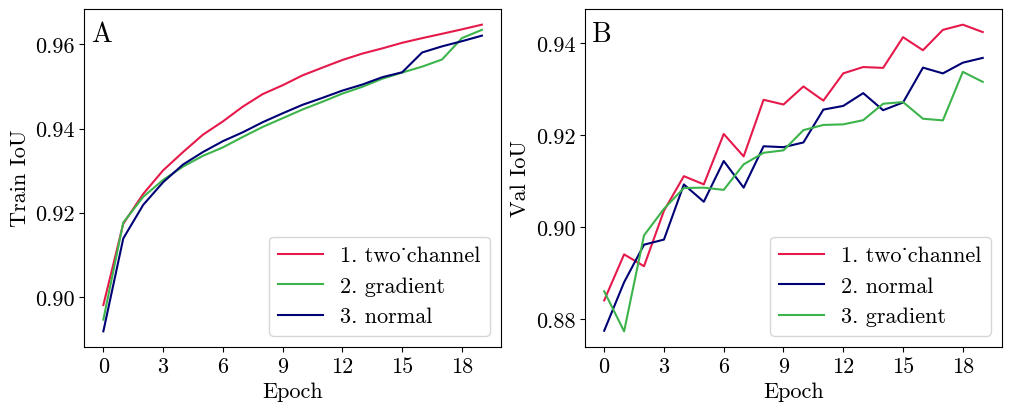

In [3]:
def plot_data_ARCHITECTURE(big_df: pd.DataFrame):
    # architecture, encoder, loss, freeze, dataset = 0, 1, 2, 3, 4
    data_name = 4 # == Loss
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')
    color_dict = dataset_feature_color_dict
    # Train Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_loss', y_column_name="Jaccard Loss", plot_title="Loss", 
    #                x_column_name="Epoch", loc='upper center', data_name=data_name, text_letter="A", legend=False, color_dict=color_dict)
    # Val  Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_volumn='val_loss', y_column_name="Loss", plot_title="Loss", 
    #                x_column_name="Epoch")
    
    # Train IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_iou_score', y_column_name="Train IoU", plot_title="Train IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="A", color_dict=color_dict, legend_font_size=16)
    # Val IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=1, y_column='val_iou_score', y_column_name="Val IoU", plot_title="Val IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="B", color_dict=color_dict, legend_font_size=16)
    
    # create_table(big_df, axs, 0, 1, 'val_iou_score', data_name=data_name, table_data_name="Dataset Feature", text_letter="B")
    data_sorted = sort_data(big_df, 'val_iou_score')
    max_val_ious = [(max_val_iou[0][0][data_name], round(max_val_iou[1],5)) for max_val_iou in data_sorted]
    max_val_ious = sorted(max_val_ious, key=lambda x: x[1], reverse=True)
    print(max_val_ious)

    return fig


feature_engieering = read_csvs("./TRAINING_RESULTS/features")    
# IoU
loss_train_fig = plot_data_ARCHITECTURE(feature_engieering)
# loss_train_fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.1/select_feature.svg")
loss_train_fig.savefig("../Overleaf_figures/Chapter5/5.1/select_feature.svg")
# loss_train_fig.show()
# Select_encoder_df

# Arch

['UnetPlusPlus', 'resnet34', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['Unet', 'resnet34', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'resnet34', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['MAnet', 'resnet34', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['PSPNet', 'resnet34', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['FPN', 'resnet34', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['PAN', 'resnet34', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['Linknet', 'resnet34', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
[('DeepLabV3Plus', 0.97619), ('FPN', 0.97436), ('PAN', 0.9743), ('PSPNet', 0.9525), ('Unet', 0.94915), ('Linknet', 0.94123), ('UnetPlusPlus', 0.94054), ('MAnet', 0.93744)]


/tmp/ipykernel_3877240/3925450401.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')


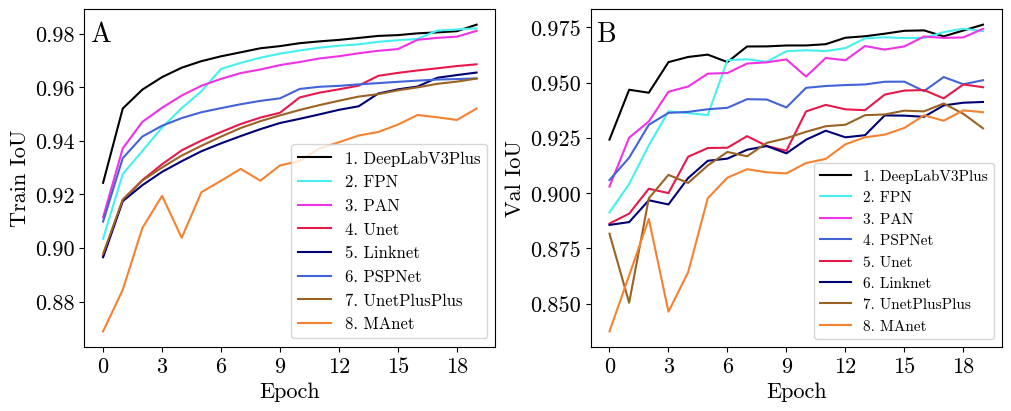

In [4]:
def plot_data_ARCHITECTURE(big_df: pd.DataFrame):
    # architecture, encoder, loss, freeze, dataset = 0, 1, 2, 3, 4
    data_name = 0 # == Loss
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')
    color_dict = architecture_color_dict
    # Train Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_loss', y_column_name="Jaccard Loss", plot_title="Loss", 
    #                x_column_name="Epoch", loc='upper center', data_name=data_name, text_letter="A", legend=False, color_dict=color_dict)
    # Val Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_volumn='val_loss', y_column_name="Loss", plot_title="Loss", x_column_name="Epoch")
    
    # Train IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_iou_score', y_column_name="Train IoU", plot_title="Train IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="A", color_dict=color_dict, legend_font_size=12)
    # Val IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=1, y_column='val_iou_score', y_column_name="Val IoU", plot_title="Val IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="B", color_dict=color_dict, legend_font_size=11)
    
    # create_table(big_df, axs, 0, 1, 'val_iou_score', data_name=data_name, table_data_name="Architectures", text_letter="B")
    data_sorted = sort_data(big_df, 'val_iou_score')
    max_val_ious = [(max_val_iou[0][0][data_name], round(max_val_iou[1],5)) for max_val_iou in data_sorted]
    max_val_ious = sorted(max_val_ious, key=lambda x: x[1], reverse=True)
    print(max_val_ious)
    return fig


Select_architecture_df = read_csvs("./TRAINING_RESULTS/meta_architectures")    
# IoU
loss_train_fig = plot_data_ARCHITECTURE(Select_architecture_df)
loss_train_fig.savefig("../Overleaf_figures/Chapter5/5.1/select_architecture.svg")
# loss_train_fig.show()
# Select_encoder_df

# Encoders

['DeepLabV3Plus', 'efficientnet-b3', 'JaccardLoss', 'Freeze_encoder_True', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'xception41', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b2', 'JaccardLoss', 'Freeze_encoder_True', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b3', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b1', 'JaccardLoss', 'Freeze_encoder_True', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b2', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'resnet34', 'JaccardLoss', 'Freeze_encoder_True', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b1', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'resnet101', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'resnet101', 'JaccardLoss', 'Freeze_encoder_True', 'two_channel', 'L

/tmp/ipykernel_3877240/1780008723.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout='constrained')


['DeepLabV3Plus', 'efficientnet-b3', 'JaccardLoss', 'Freeze_encoder_True', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'xception41', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b2', 'JaccardLoss', 'Freeze_encoder_True', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b3', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b1', 'JaccardLoss', 'Freeze_encoder_True', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b2', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'resnet34', 'JaccardLoss', 'Freeze_encoder_True', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b1', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'resnet101', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'resnet101', 'JaccardLoss', 'Freeze_encoder_True', 'two_channel', 'L

/tmp/ipykernel_3877240/1780008723.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout='constrained')


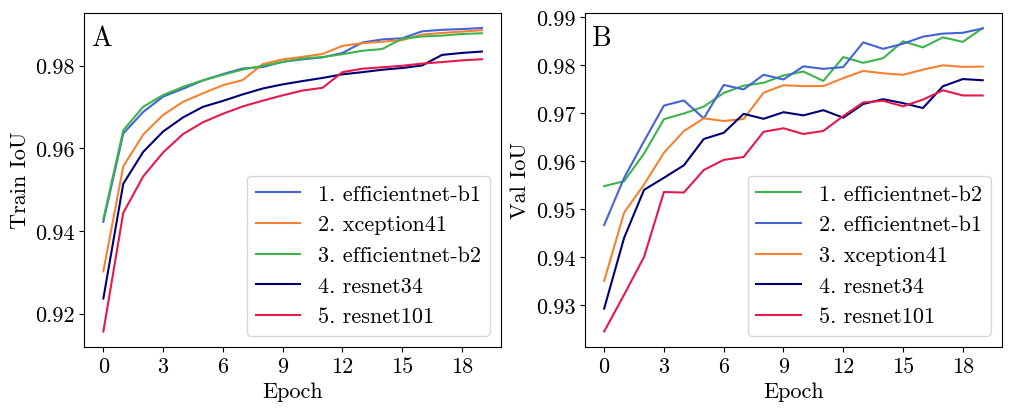

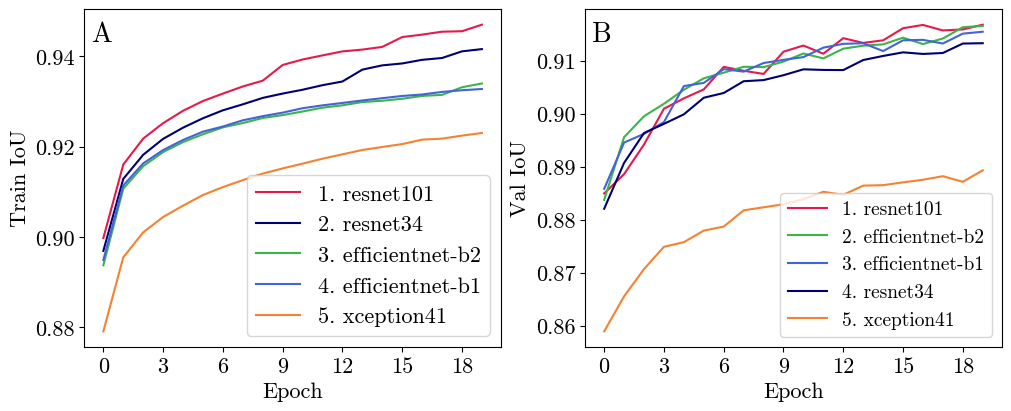

In [5]:
def plot_data_Encoder(big_df: pd.DataFrame, legend_font_size=16):
    # architecture, encoder, loss, freeze, dataset = 0, 1, 2, 3, 4
    data_name = 1 # == Loss
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout='constrained')
    color_dict = encoder_color_dict

    # filter = "freeze_encoder == False & encoder != 'resnetv2_50' & encoder != 'resnetv2_101'"
    # Train Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_loss', y_column_name="Jaccard Loss", plot_title="Loss", 
    #                x_column_name="Epoch", loc='upper center', data_name=data_name, text_letter="A", legend=False, color_dict=color_dict)
    
    # Val Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_volumn='val_loss', y_column_name="Loss", plot_title="Loss", 
    #                x_column_name="Epoch")
    
    # Table val score
    # create_table(big_df, axs, 0, 1, 'val_iou_score', data_name=data_name, table_data_name="Architectures", text_letter="B")

    # Train IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_iou_score', y_column_name="Train IoU", plot_title="Train IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="A", color_dict=color_dict, legend_font_size=16)
    # Val IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=1, y_column='val_iou_score', y_column_name="Val IoU", plot_title="Val IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="B", color_dict=color_dict, legend_font_size=legend_font_size)
    
    data_sorted = sort_data(big_df, 'val_iou_score')
    max_val_ious = [(max_val_iou[0][0][data_name], round(max_val_iou[1],5)) for max_val_iou in data_sorted]
    max_val_ious = sorted(max_val_ious, key=lambda x: x[1], reverse=True)
    print(max_val_ious)
    return fig


Select_encoder_df = read_csvs("./TRAINING_RESULTS/encoders")    
Select_encoder_df.query("freeze_encoder == False & encoder != 'efficientnet-b3' & encoder != 'resnetv2_50' & encoder != 'resnetv2_101'", inplace=True)

loss_train_fig = plot_data_Encoder(Select_encoder_df)
loss_train_fig.savefig("../Overleaf_figures/Chapter5/5.1/select_encoder.svg")

Select_encoder_df = read_csvs("./TRAINING_RESULTS/encoders")    
Select_encoder_df.query("freeze_encoder == True & encoder != 'efficientnet-b3' & encoder != 'resnetv2_50' & encoder != 'resnetv2_101'", inplace=True)
loss_train_fig = plot_data_Encoder(Select_encoder_df, legend_font_size=14)
loss_train_fig.savefig("../Overleaf_figures/Chapter5/5.1/select_encoder_frozen.svg")

['DeepLabV3Plus', 'efficientnet-b2', 'DiceLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b2', 'JaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b2', 'BCELoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b2', 'BCEJaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b2', 'FocalLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b2', 'BinaryLovaszLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'efficientnet-b2', 'BCEDiceLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
[('BCEJaccardLoss', 0.98839), ('DiceLoss', 0.98714), ('BCELoss', 0.98705), ('BCEDiceLoss', 0.98664), ('JaccardLoss', 0.98579), ('FocalLoss', 0.98511), ('BinaryLovaszLoss', 0.98254)]


/tmp/ipykernel_3877240/3996757140.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')


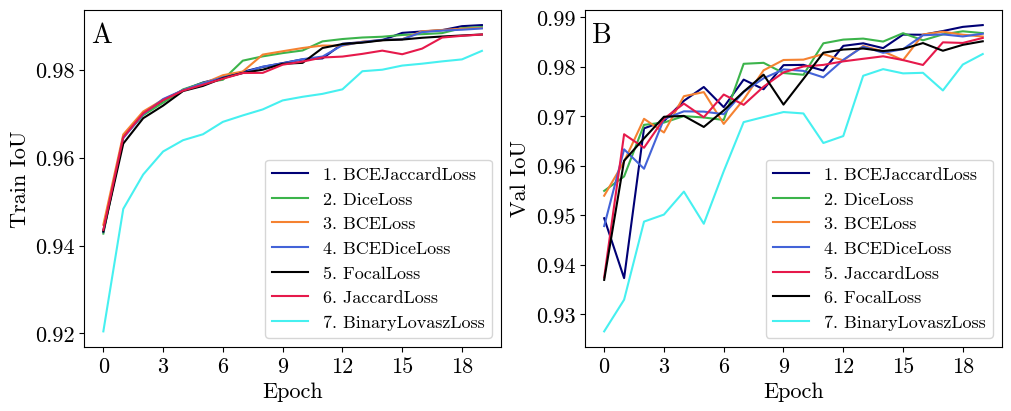

In [6]:
def plot_data_ARCHITECTURE(big_df: pd.DataFrame):
    # architecture, encoder, loss, freeze, dataset = 0, 1, 2, 3, 4
    data_name = 2 # == Loss
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')
    color_dict=loss_color_dict
    # Train Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_loss', y_column_name="Loss", plot_title="Loss", 
    #                x_column_name="Epoch", loc='upper center', data_name=data_name, text_letter="A", legend=False, color_dict=color_dict)
    # Val Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_volumn='val_loss', y_column_name="Loss", plot_title="Loss", 
    #                x_column_name="Epoch")
    
    # Train IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_iou_score', y_column_name="Train IoU", plot_title="Train IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="A", color_dict=color_dict, legend_font_size=13)
    # Val IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=1, y_column='val_iou_score', y_column_name="Val IoU", plot_title="Val IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="B", color_dict=color_dict, legend_font_size=13)
    
    # create_table(big_df, axs, 0, 1, 'val_iou_score', data_name=data_name, table_data_name="Loss function", text_letter="B")
    data_sorted = sort_data(big_df, 'val_iou_score')
    max_val_ious = [(max_val_iou[0][0][data_name], round(max_val_iou[1],5)) for max_val_iou in data_sorted]
    max_val_ious = sorted(max_val_ious, key=lambda x: x[1], reverse=True)
    print(max_val_ious)
    
    return fig


Select_encoder_df = read_csvs("./TRAINING_RESULTS/loss_functions")
# IoU
loss_train_fig = plot_data_ARCHITECTURE(Select_encoder_df)
loss_train_fig.savefig("../Overleaf_figures/Chapter5/5.1/select_loss.svg")
# loss_train_fig.show()
# Select_encoder_df
# Select_encoder_df[['loss_func', 'val_iou_score']]

# Training further 60 epochs

['DeepLabV3Plus', 'timm-efficientnet-b2', 'BCEJaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.001']
['DeepLabV3Plus', 'timm-efficientnet-b2', 'BCEJaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.0001']
['DeepLabV3Plus', 'timm-efficientnet-b2', 'BCEJaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.00001']
[('0.00001', 0.99028), ('0.0001', 0.99014), ('0.001', 0.98983)]


/tmp/ipykernel_3877240/2114218496.py:10: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')


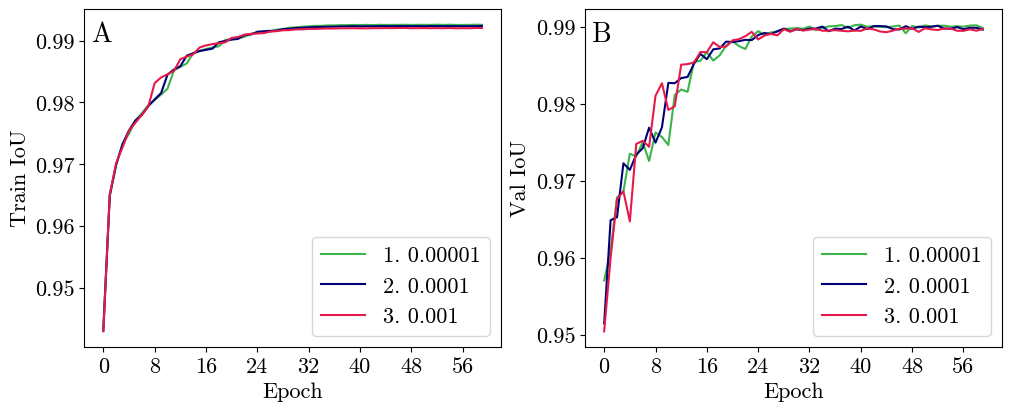

In [7]:
LR_color_dict = {
    '0.001': '#e6194b', # 0.001
    '0.0001': '#000075',
    '0.00001': '#3cb44b',
}

def plot_data_training_further(big_df: pd.DataFrame):
    # architecture, encoder, loss, freeze, dataset = 0, 1, 2, 3, 4
    data_name = 5 # == Loss
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')
    color_dict=LR_color_dict
    # Train Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_loss', y_column_name="Loss", plot_title="Loss", 
    #                x_column_name="Epoch", loc='upper center', data_name=data_name, text_letter="A", legend=False, color_dict=color_dict)
    # Val Loss 
    # create_sub_fig(big_df, axs=axs, row=0, col=0, y_volumn='val_loss', y_column_name="Loss", plot_title="Loss", 
    #                x_column_name="Epoch")
    # Train IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_iou_score', y_column_name="Train IoU", plot_title="Train IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="A", color_dict=color_dict, legend_font_size=16)
    # Val IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=1, y_column='val_iou_score', y_column_name="Val IoU", plot_title="Val IoU", 
                   x_column_name="Epoch", data_name=data_name, text_letter="B", color_dict=color_dict, legend_font_size=16)
    
    # baseline_df = read_csvs("./TRAINING_RESULTS_new/baseline")
    # create_sub_fig(baseline_df, axs=axs, row=0, col=0, y_column='train_iou_score', y_column_name="Train IoU", plot_title="Train IoU", 
    #                x_column_name="Epoch", data_name=0, text_letter="A", color_dict=architecture_color_dict, legend_font_size=16)
    
    # create_table(big_df, axs, 0, 1, 'val_iou_score', data_name=data_name, table_data_name="Loss function", text_letter="B")
    data_sorted = sort_data(big_df, 'val_iou_score')
    max_val_ious = [(max_val_iou[0][0][data_name], round(max_val_iou[1],5)) for max_val_iou in data_sorted]
    max_val_ious = sorted(max_val_ious, key=lambda x: x[1], reverse=True)
    print(max_val_ious)
    
    return fig


training_further_df = read_csvs("./TRAINING_RESULTS/training_further")
# IoU
train_further_fig = plot_data_training_further(training_further_df)
train_further_fig.savefig("../Overleaf_figures/Chapter5/5.1/training_further.svg")

['DeepLabV3Plus', 'timm-efficientnet-b2', 'BCEJaccardLoss', 'Freeze_encoder_False', 'two_channel', 'LR_0.00001']
[('0.00001', 0.99028)]


/tmp/ipykernel_3877240/317665859.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(2, 3, figsize=(12, 8), layout='constrained')


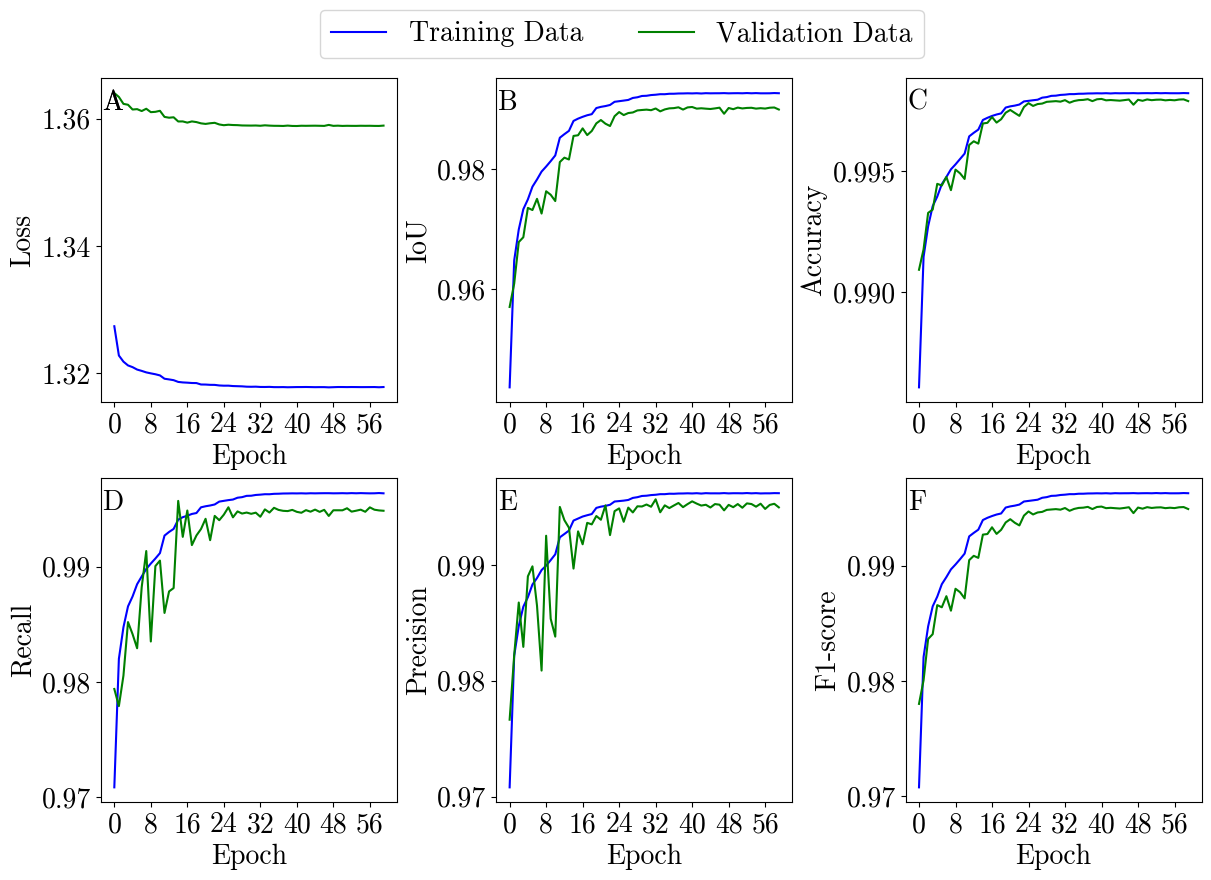

In [12]:
def plot_data_training_further(big_df: pd.DataFrame):
    # architecture, encoder, loss, freeze, dataset = 0, 1, 2, 3, 4
    data_name = 5 # == Loss
    fig, axs = plt.subplots(2, 3, figsize=(12, 8), layout='constrained')
    color_dict=LR_color_dict
    color_train = 'blue'
    color_val = 'green'
    # Train Loss 
    create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='train_loss', y_column_name="Loss", plot_title="Loss", 
                   x_column_name="Epoch", data_name=data_name, text_letter="A", color_dict=color_dict, 
                   legend_font_size=16, legend=False, static_color=color_train, static_label='Training')    
    # Val Loss 
    create_sub_fig(big_df, axs=axs, row=0, col=0, y_column='val_loss', y_column_name="Loss", plot_title="Loss", 
                   x_column_name="Epoch", loc='upper right', data_name=data_name, text_letter="A", color_dict=color_dict, 
                   legend_font_size=16, legend=False, static_color=color_val, static_label='Validation')


    # Train IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=1, y_column='train_iou_score', y_column_name="", plot_title="", 
                   x_column_name="Epoch", data_name=data_name, text_letter="B", color_dict=color_dict, legend_font_size=16, legend=False, 
                   static_color=color_train, static_label='Train IoU')
    # Val IoU 
    create_sub_fig(big_df, axs=axs, row=0, col=1, y_column='val_iou_score', y_column_name="IoU", plot_title="", 
                   x_column_name="Epoch", data_name=data_name, color_dict=color_dict, legend_font_size=16, legend=False, 
                   static_color=color_val, static_label='Val IoU')
    
    # Train Accuracy 
    create_sub_fig(big_df, axs=axs, row=0, col=2, y_column='train_accuracy', y_column_name="Accuracy", plot_title="", 
                   x_column_name="Epoch", data_name=data_name, text_letter="C", color_dict=color_dict, legend_font_size=16, legend=True, 
                   static_color=color_train, static_label='Train Accuracy')
    # Val IAccuracyoU 
    create_sub_fig(big_df, axs=axs, row=0, col=2, y_column='val_accuracy', y_column_name="Accuracy", plot_title="", 
                   x_column_name="Epoch", data_name=data_name, color_dict=color_dict, legend_font_size=16, legend=False, 
                   static_color=color_val, static_label='Val Accuracy')
    
    # Train Recall 
    create_sub_fig(big_df, axs=axs, row=1, col=0, y_column='train_recall', y_column_name="Recall", plot_title="", 
                   x_column_name="Epoch", data_name=data_name, text_letter="D", color_dict=color_dict, legend_font_size=16, legend=True, 
                   static_color=color_train, static_label='Train Recall')
    # Val Recall
    create_sub_fig(big_df, axs=axs, row=1, col=0, y_column='val_recall', y_column_name="Recall", plot_title="", 
                   x_column_name="Epoch", data_name=data_name, color_dict=color_dict, legend_font_size=16, legend=False, 
                   static_color=color_val, static_label='Val Recall')
    
    # Train Precision 
    create_sub_fig(big_df, axs=axs, row=1, col=1, y_column='train_precision', y_column_name="Precision", plot_title="", 
                   x_column_name="Epoch", data_name=data_name, text_letter="E", color_dict=color_dict, legend_font_size=16, legend=True, 
                   static_color=color_train, static_label='Training Data') # static_label='Train Accuracy'
    # Val Precision
    create_sub_fig(big_df, axs=axs, row=1, col=1, y_column='val_precision', y_column_name="Precision", plot_title="", 
                   x_column_name="Epoch", data_name=data_name, color_dict=color_dict, legend_font_size=16, legend=False, 
                   static_color=color_val, static_label='Validation Data') # static_label='Val Accuracy'
    
    # Train F1 score 
    create_sub_fig(big_df, axs=axs, row=1, col=2, y_column='train_fscore', y_column_name="Fscore", plot_title="", 
                   x_column_name="Epoch", data_name=data_name, text_letter="F", color_dict=color_dict, legend_font_size=16, legend=True, 
                   static_color=color_train, static_label='Train Accuracy')
    # Val F1 score 
    create_sub_fig(big_df, axs=axs, row=1, col=2, y_column='val_fscore', y_column_name="F1-score", plot_title="", 
                   x_column_name="Epoch", data_name=data_name, color_dict=color_dict, legend_font_size=16, legend=False, 
                   static_color=color_val, static_label='Val Accuracy')
    

    # create_table(big_df, axs, 0, 1, 'val_iou_score', data_name=data_name, table_data_name="Loss function", text_letter="B")
    data_sorted = sort_data(big_df, 'val_iou_score')
    max_val_ious = [(max_val_iou[0][0][data_name], round(max_val_iou[1],5)) for max_val_iou in data_sorted]
    max_val_ious = sorted(max_val_ious, key=lambda x: x[1], reverse=True)
    print(max_val_ious)

    lines_labels = [axs[1,1].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels, loc = (0.5, -0.08), ncol=4,)
    # fig.legend(lines, labels, loc = 'lower center', ncol=4,)

    fig.legend(lines, labels, loc='center left', bbox_to_anchor=(0.25, 1.05), ncol=4,)
    # fig.legend(lines, labels, loc='center left', bbox_to_anchor=(0.25, -0.05), ncol=4,)
    # fig.tight_layout()
    return fig

plt.rcParams.update({'font.size': 20})

training_further_df = read_csvs("./TRAINING_RESULTS/best")
# IoU
train_further_fig = plot_data_training_further(training_further_df)
train_further_fig.savefig("../Overleaf_figures/Chapter5/5.1/best.svg", bbox_inches="tight")

In [25]:
data_sorted = sort_data(training_further_df, 'val_iou_score')
max_val_ious = [(max_val_iou[0][0][5], round(max_val_iou[1],5)) for max_val_iou in data_sorted]
max_val_ious = sorted(max_val_ious, key=lambda x: x[1], reverse=True)
# print(max_val_ious)
data_sorted[0][0][1].iloc[40]

train_iou_score                0.992538
train_accuracy                 0.998215
train_fscore                   0.996254
train_precision                 0.99615
train_recall                   0.996359
train_loss                     1.317821
val_iou_score                  0.990281
val_accuracy                   0.997986
val_fscore                     0.995111
val_precision                  0.995468
val_recall                      0.99476
val_loss                       1.358844
parameters                      8642451
freeze_encoder                    False
inference_time                 0.013012
architecture              DeepLabV3Plus
encoder            timm-efficientnet-b2
loss_func                BCEJaccardLoss
dataset                     two_channel
lr                              0.00001
Name: 40, dtype: object

In [9]:
training_further_df.columns

Index(['train_iou_score', 'train_accuracy', 'train_fscore', 'train_precision',
       'train_recall', 'train_loss', 'val_iou_score', 'val_accuracy',
       'val_fscore', 'val_precision', 'val_recall', 'val_loss', 'parameters',
       'freeze_encoder', 'inference_time', 'architecture', 'encoder',
       'loss_func', 'dataset', 'lr'],
      dtype='object')

# Confusion matrix

https://stackoverflow.com/questions/62755471/how-to-create-a-confusion-matrices-for-an-image-segmentation-task